In [92]:
import numpy as np
import torch
import math
import random
from random import randint, choice
import matplotlib.pyplot as plt
from util import *
from IPython.display import clear_output

In [516]:
class UAVEnvironment:
    """
    Game environment for UAV test
    
    ---Map---
    
    y-axis(length)
    |
    |
    |
    |
    |
    |
     _______________________ x-axis(width)
     
    Hight is a fixed value
    
    """
    def __init__(self, config):
        # Game config
        self.action_space = (0, 1, 2, 3) # up, right, down, left, total 4 actions
        self.total_steps = config["total_steps"] # when the game end
        self.current_step = 0
        if config["is_random_env"] == False:
            self.random_seed = config["random_seed"]
            random.seed(self.random_seed)
        
        # Map config
        self.map = dict(width=config["map"]["width"], length=config["map"]["length"], height=config["map"]["height"])
        self.UAV_speed = config["UAV_speed"]
        self.UAV_initial_pos = config["UAV_initial_pos"] # a tuple
        self.UAV_current_pos = self.UAV_initial_pos
        self.number_of_user = config["number_of_user"]
        self.users_pos = list()
        for i in range(0, self.number_of_user):
            self.users_pos.append((randint(0, self.map["width"]), randint(0, self.map["length"])))
        
        # Wireless config
        self.g0 = config["wireless_parameter"]["g0"]
        self.B = config["wireless_parameter"]["B"]
        self.Pk = config["wireless_parameter"]["Pk"]
        self.noise = config["wireless_parameter"]["noise"]
        
    def get_reward(self, UAV_pos):
        # One step Reward is define as the summation of all user's utility
        reward = 0
        for user_index in range(0, self.number_of_user):
            gkm = self.g0 / (self.map["height"] ** 2 + (UAV_pos[0] - self.users_pos[user_index][0]) ** 2 + (UAV_pos[1] - self.users_pos[user_index][1]) ** 2)
            user_utility = self.B * math.log(1 + self.Pk * gkm / self.noise, 2)
            reward = reward + user_utility
        return reward / (10 ** 6) # Use Mkbps as signal basic unit
    
    def transition_dynamics(self, action, speed, state):
        # given the action (direction), calculate the next state (UAV current position)
        assert action in self.action_space
        next_UAV_pos = list(state)
        if action == 0:
            # move up
            next_UAV_pos[1] = min(next_UAV_pos[1] + speed, self.map["length"])
        if action == 1:
            # move right
            next_UAV_pos[0] = min(next_UAV_pos[0] + speed, self.map["width"])
        if action == 2:
            # move down
            next_UAV_pos[1] = max(next_UAV_pos[1] - speed, 0)
        if action == 3:
            # move left
            next_UAV_pos[0] = max(next_UAV_pos[0] - speed, 0)
        return tuple(next_UAV_pos)
    
    def get_transition(self):
        # This function only works for model based, we are trying to disable this function to try more algorithm
        # Return a table of transition, we assume UAV use fixed flying speed
        """
        Structure:
        transition[
            x_0[
                y_0[
                    {next_state, reward}, # for action 1
                    {next_state, reward}, # for action 2
                    ...
                    {next_state, reward}, # for action 20
                ],
                y_1*v[],
                ...
                y_h-1*v[]
            ],
            x_1*v[],
            x_2*v[],
            ...
            x_w-1*v[]
        ]
        
        """
        transition = list()
        for state_x in range(0, int(self.map["width"] / self.UAV_speed) + 1):
            transition.append(list())
            for state_y in range(0, int(self.map["length"] / self.UAV_speed) + 1):
                transition[state_x].append(list())
                for action in self.action_space:
                    next_state = self.transition_dynamics(action, self.UAV_speed, (state_x * self.UAV_speed, state_y * self.UAV_speed))
                    reward = self.get_reward(next_state)
                    transition[state_x][state_y].append(dict(next_state=next_state,reward=reward))
        return transition
                    
    def step(self, action, speed=-1):
        # assume we use the max speed as the default speed, when come near to the opt-position, we can slow down the speed
        if speed < 0 or speed >= self.UAV_speed:
            speed = self.UAV_speed
            
        self.UAV_current_pos = self.transition_dynamics(action, speed, self.UAV_current_pos)
        self.current_step = self.current_step + 1
        done = False
        if self.current_step == self.total_steps:
            done =  True
        return self.UAV_current_pos, self.get_reward(self.UAV_current_pos), done
    
    def action_sample(self):
        return choice(self.action_space)
    
    def reset(self):
        self.current_step = 0
        self.UAV_current_pos = self.UAV_initial_pos
        #self.users_pos = list()
        #for i in range(0, self.number_of_user):
        #    self.users_pos.append((randint(0, self.map["width"]), randint(0, self.map["length"])))
        return self.UAV_current_pos
        
    def print_attribute(self):
        attrs = vars(self)
        print(', '.join("%s: %s" % item for item in attrs.items()))
        
    def print_map(self):
        x_list = [pos[0] for pos in self.users_pos]
        y_list = [pos[1] for pos in self.users_pos]
        x_list.append(self.UAV_current_pos[0])
        y_list.append(self.UAV_current_pos[1])
        
        colors = np.array(["red", "green"])
        sizes = []
        colors_map = []
        for i in range(0, self.number_of_user):
            sizes.append(25)
            colors_map.append(1)
        sizes.append(50)
        colors_map.append(0)
        plt.scatter(x_list, y_list, c=colors[colors_map], s=sizes) 
        plt.axis([0, self.map["width"], 0, self.map["length"]])
        plt.show()
        

In [517]:
environment_config = dict(
    total_steps = 10,
    random_seed = 0,
    is_random_env = False,
    map=dict(
        width=1000,
        length=1000,
        height=100
    ),
    number_of_user = 10,
    UAV_speed = 20,
    UAV_initial_pos = (0, 0),
    wireless_parameter = dict(
        g0 = 10 ** (-5),
        B = 10 ** (6),
        Pk = 0.1,
        noise = 10 ** (-9)
    )
)

action_space: (0, 1, 2, 3), total_steps: 10, current_step: 0, random_seed: 0, map: {'width': 1000, 'length': 1000, 'height': 100}, UAV_speed: 20, UAV_initial_pos: (0, 0), UAV_current_pos: (0, 0), number_of_user: 10, users_pos: [(864, 394), (776, 911), (430, 41), (265, 988), (523, 497), (414, 940), (802, 849), (310, 991), (488, 366), (597, 913)], g0: 1e-05, B: 1000000, Pk: 0.1, noise: 1e-09


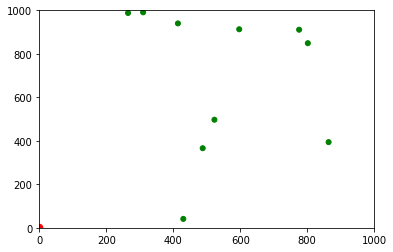

In [519]:
myGame = UAVEnvironment(environment_config)
myGame.print_attribute()
myGame.print_map()

In [493]:
def evaluate(policy, config, num_episodes=1, render=False):
    env = UAVEnvironment(config)
    
    rewards = []
    for i in range(num_episodes):
        obs = env.reset()
        # all policy will return a direction and a speed
        act_direction, act_speed = policy(obs)
        ep_reward = 0
        while True:
            obs, reward, done = env.step(act_direction, act_speed)
            act_direction, act_speed = policy(obs)
            ep_reward += reward
            if done:
                break
            if render = True:
                clear_output(wait=True)
                env.print_attribute()
                print("Current Step: {}".format(env.current_step))
                print("Policy choice direction: {}, speed: {}".format(act_direction, act_speed))
                print("UAV current position x: {}, y: {}".format(env.UAV_current_pos[0], env.UAV_current_pos[1]))
                print("Current step reward: {}, episodes rewards: {}".format(reward, ep_reward))
                env.print_map()
                wait(sleep=0.2)
        rewards.append(ep_reward)
    return np.mean(rewards)

def run(trainer_cls, config=None, reward_threshold=None):
    pass


In [494]:
# Basic Class for all RL algorithm
class UAVTrainer: 
    def __init__(self, config):
        self.config = config
        self.env = UAVEnvironment(self.config)
    
    def train(self):
        pass
    
    def policy(self):
        pass

In [495]:
# Start from random policy
class UAVTrainerRandomPolicy(UAVTrainer):
    def __init__(self, config):
        super().__init__(config)
        
    def policy(self, obs):
        max_speed = self.env.UAV_speed
        return self.env.action_sample(), max_speed

random_policy_config = environment_config
trainer = UAVTrainerRandomPolicy(random_policy_config)
trainer.env.print_attribute()
print("Mean Reward is: {}".format(evaluate(trainer.policy, config = random_policy_config, num_episodes=1, render=False))) # Enable render=True can see the agent behavior

action_space: (0, 1, 2, 3), total_steps: 10, current_step: 0, random_seed: 0, map: {'width': 120, 'length': 60, 'height': 100}, UAV_speed: 20, UAV_initial_pos: (0, 0), UAV_current_pos: (0, 0), number_of_user: 1, users_pos: [(108, 24)], g0: 1e-05, B: 1000000, Pk: 0.1, noise: 1e-09
Mean Reward is: 0.6778269285353753


In [526]:
import copy

# Value Iteration, Tabular, transition dynamic is known, assume only use fixed speed to reduce action space
class UAVTrainerValueIteration(UAVTrainer):
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.transitions = self.env.get_transition()
        self.q_table = []
        self.obs_dim = (int(self.env.map["width"] / self.env.UAV_speed), int(self.env.map["length"] / self.env.UAV_speed))
        self.act_dim = len(self.env.action_space)
        self.gamma = config["gamma"]
        
        for x in range(0, self.obs_dim[0]+1):
            self.q_table.append(list())
            for y in range(0, self.obs_dim[1]+1):
                self.q_table[x].append(0)
            
    def get_transition(self, state, act):
        transition = self.transitions[state[0]][state[1]][act]
        return transition["next_state"], transition["reward"]
    
    def print_transitions(self):
        print("Transition width {}, length {}, number of act {}".format(len(self.transitions), len(self.transitions[0]), len(self.transitions[0][0])))
        print(self.transitions)
        
    def print_table(self):
        for j in range(len(self.q_table[0])-1, -1, -1):
            for i in range(0, len(self.q_table)):
                print(self.q_table[i][j], end =" ")
            print("")
            
            
    def copy_current_table(self):
        old_table = []
        for x in range(0, self.obs_dim[0]+1):
            old_table.append(list())
            for y in range(0, self.obs_dim[1]+1):
                old_table[x].append(self.q_table[x][y])
        return old_table

    def update_value_function(self):
        old_table = self.copy_current_table()
        for state_x in range(self.obs_dim[0] + 1):
            for state_y in range(self.obs_dim[1] + 1):
                state_value = 0
                state_action_values = [0 for i in range(0, self.act_dim)]

                for act in range(self.act_dim):
                    next_state, reward = self.get_transition((state_x, state_y), act)
                    table_x = int(next_state[0] / self.env.UAV_speed)
                    table_y = int(next_state[1] / self.env.UAV_speed)
                    #print(table_x, table_y)
                    state_action_values[act] = state_action_values[act] + reward + self.gamma * old_table[table_x][table_y]   
                state_value = np.max(state_action_values)
                self.q_table[state_x][state_y] = state_value
                #print("Update x: {}, y: {} to value {}".format(state_x, state_y, state_value))
            
    def train(self):
        old_state_value_table = self.copy_current_table()
        current_step = 0
        while current_step < self.config['max_iteration']:  
            current_step = current_step + 1
            self.update_value_function()
            if current_step % self.config["evaluate_interval"] == 0:
                print("Iteration {}, Mean Reward is: {}".format(current_step, evaluate(self.policy, config = self.config, num_episodes=1, render=False)))
                #print("Iteration {}, Mean Reward is: {}".format(current_step, 0))
                # check exist
                stop = True
                flag = 0
                for x in range(self.obs_dim[0] + 1):
                    for y in range(self.obs_dim[1] + 1):
                        if abs(self.q_table[x][y] - old_state_value_table[x][y]) > self.config["return_threshold"]:
                            stop = False
                            flag = 1
                    if flag == 1:
                        break
                if stop == True:
                    print("Train converge at i = {}".format(current_step))
                    current_step = self.config['max_iteration']
                else:
                    old_state_value_table = self.copy_current_table()

    def policy(self, obs):
        table_x = int(obs[0] / self.env.UAV_speed)
        table_y = int(obs[1] / self.env.UAV_speed)
        next_state_value_list = []
        for act in range(0, self.act_dim):
            next_state, reward = self.get_transition((table_x, table_y), act)
            next_state_x = int(next_state[0] / self.env.UAV_speed)
            next_state_y = int(next_state[1] / self.env.UAV_speed)
            next_state_value_list.append(self.q_table[next_state_x][next_state_y])
        #print(next_state_value_list, act)
        act = np.argmax(next_state_value_list)
        return act, self.env.UAV_speed

value_iteration_config = merge_config(dict(
    max_iteration=10000,
    total_steps = 50,
    number_of_user = 10,
    map=dict(
        width=1000,
        length=1000,
        height=10000
    ),
    evaluate_interval=100,  # don't need to update policy each iteration
    gamma=0.9,
    return_threshold=1,
    random_seed = 10,
    is_random_env = False
), environment_config)
trainer = UAVTrainerValueIteration(value_iteration_config)
trainer.env.print_attribute()
#trainer.print_transitions()
trainer.train()
#trainer.print_table()


action_space: (0, 1, 2, 3), total_steps: 50, current_step: 0, random_seed: 10, map: {'width': 1000, 'length': 1000, 'height': 10000}, UAV_speed: 20, UAV_initial_pos: (0, 0), UAV_current_pos: (0, 0), number_of_user: 10, users_pos: [(585, 33), (439, 494), (591, 15), (211, 473), (832, 503), (843, 284), (669, 830), (164, 35), (533, 501), (335, 77)], g0: 1e-05, B: 1000000, Pk: 0.1, noise: 1e-09
Iteration 100, Mean Reward is: 0.007197806641099489
Train converge at i = 100


action_space: (0, 1, 2, 3), total_steps: 50, current_step: 49, random_seed: 10, map: {'width': 1000, 'length': 1000, 'height': 10000}, UAV_speed: 20, UAV_initial_pos: (0, 0), UAV_current_pos: (520, 340), number_of_user: 10, users_pos: [(585, 33), (439, 494), (591, 15), (211, 473), (832, 503), (843, 284), (669, 830), (164, 35), (533, 501), (335, 77)], g0: 1e-05, B: 1000000, Pk: 0.1, noise: 1e-09
Current Step: 49
Policy choice direction: 0, speed: 20
UAV current position x: 520, y: 340
Current step reward: 0.00014409658377021337, episodes rewards: 0.007053711526565199


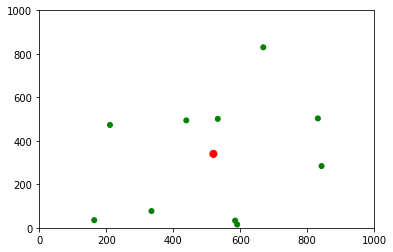

Mean Reward is: 0.007197806641099489


In [527]:
print("Mean Reward is: {}".format(evaluate(trainer.policy, config = value_iteration_config, num_episodes=1, render=True))) # Enable render=True can see the agent behavior

In [396]:
import random

print ("Random number with seed 30")
random.seed(0)
print ("first - ", random.randint(25,50))

#will generate a same random number as previous
print ("Second - ", random.randint(25,50))

#will generate a same random number as previous
random.seed(0)
print ("Third - ", random.randint(25,50))
print ("Third - ", random.randint(25,50))

Random number with seed 30
first -  37
Second -  49
Third -  37
Third -  49
